#Microplastic color and size detection software


##Installing YOLOv8

In [1]:
#Installing YOLOv8 from pip
!pip install ultralytics==8.0.196


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 8.5 MB/s eta 0:00:00


In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/107.7 GB disk)


##Detection given by the previously trained model

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


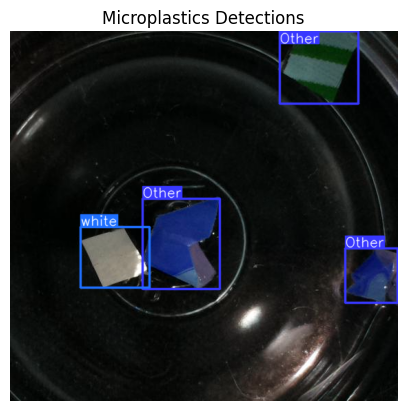

In [3]:
#Libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Load the trained model
model = YOLO('best.pt')

# Load an image for detection
img = cv2.imread('/content/1.jpg')

# Perform detection
results = model.predict(img)

# Show the image with the detections
plt.figure(figsize=(5, 5))
plt.imshow(results[0].plot(False))
plt.axis('off')  # Ocultar los ejes
plt.title("Microplastics Detections")
plt.show()

##Microplastic quantity graph

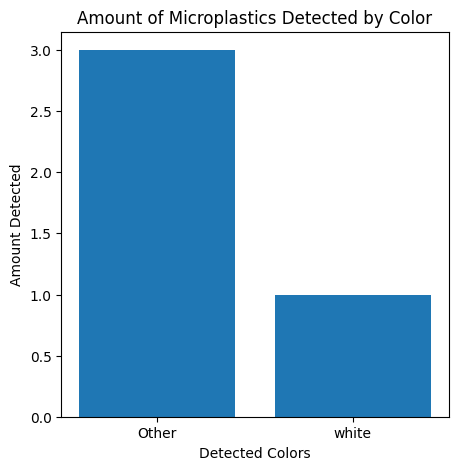

In [4]:
# Initializes a list to store the detected classes
detected_classes = []

# Loop through the results and store the detected classes
for result in results:
    for box in result.boxes:
        cls = int(box.cls[0])
        detected_classes.append(cls)

# Count the number of objects detected per class
class_counts = Counter(detected_classes)

# Get class names from the model
class_names = model.names

# Prepare the names of the detected classes and their quantities
labels = [class_names[cls] for cls in class_counts.keys()]
counts = list(class_counts.values())

# Create bar chart with the number of detections per class
plt.figure(figsize=(5, 5))
plt.bar(labels, counts)
plt.xlabel('Detected Colors')
plt.ylabel('Amount Detected')
plt.title('Amount of Microplastics Detected by Color')
plt.show()


In [5]:
# Save data to .csv files

df_classes = pd.DataFrame({'Color': labels, 'Count': counts})
print(df_classes)
df_classes.to_csv('amount.csv', index=False)


   Color  Count
0  Other      3
1  white      1


##Sizes

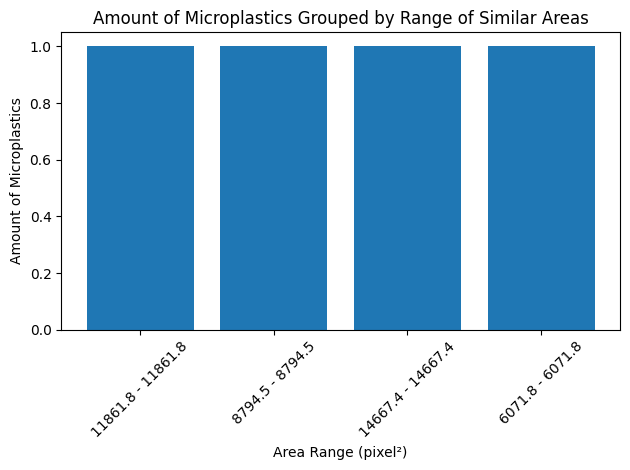

In [6]:
# Initialize lists to store detection data
areas = []

# Loop through the results and calculate the size of each detection, displaying the color name
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        width = x2 - x1
        length = y2 - y1
        area = width * length
        cls = int(box.cls[0])
        class_name = model.names[cls]
        areas.append(area)

# Define ranges for similar areas
tolerancia = 100
agrupaciones = []

for area in areas:
    encontrado = False
    for grupo in agrupaciones:

        if abs(area - grupo['promedio']) <= tolerancia:
            grupo['areas'].append(area)
            grupo['promedio'] = sum(grupo['areas']) / len(grupo['areas'])
            encontrado = True
            break
    if not encontrado:
        agrupaciones.append({'areas': [area], 'promedio': area})

rangos = [(min(grupo['areas']), max(grupo['areas'])) for grupo in agrupaciones]
cantidades = [len(grupo['areas']) for grupo in agrupaciones]

plt.figure()
plt.bar(range(len(rangos)), cantidades)

plt.xticks(
    range(len(rangos)),
    [f"{rango[0]:.1f} - {rango[1]:.1f}" for rango in rangos], rotation=45)
plt.xlabel('Area Range (pixel²)')
plt.ylabel('Amount of Microplastics')
plt.title('Amount of Microplastics Grouped by Range of Similar Areas')
plt.tight_layout()
plt.show()


In [7]:
width = []
length = []
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        width.append(x2 - x1)
        length.append(y2 - y1)
df_areas = pd.DataFrame(areas, columns=['Area(pixel^2)'])


classes = [model.names[int(box.cls[0])] for result in results for box in result.boxes]

df_areas['Color'] = classes

df_areas['Range(pixel^2)'] = [f"{rango[0]:.1f} - {rango[1]:.1f}" for rango in rangos]


df_areas['Width(pixel)'] = width
df_areas['Length(pixel)'] = length
df_areas = df_areas[['Color', 'Width(pixel)', 'Length(pixel)', 'Area(pixel^2)','Range(pixel^2)']]
print(df_areas)

df_areas.to_csv('combined_data.csv', index=False)


   Color      Width(pixel)     Length(pixel)       Area(pixel^2)  \
0  Other  tensor(113.2717)  tensor(104.7200)  tensor(11861.8125)   
1  white   tensor(99.9718)   tensor(87.9702)   tensor(8794.5371)   
2  Other  tensor(112.0741)  tensor(130.8726)  tensor(14667.4229)   
3  Other   tensor(76.3407)   tensor(79.5356)   tensor(6071.8042)   

      Range(pixel^2)  
0  11861.8 - 11861.8  
1    8794.5 - 8794.5  
2  14667.4 - 14667.4  
3    6071.8 - 6071.8  
